# I. Preparing the data

## 1. Downloading the xls data from the public url

### [mettre le code de Anthony]

## 2. Adding the weather to the sample dataset

We are using the free API of Open Weather, which provides weather data from 1940 until now. 
The API call has different parameters: some are required (latitude, longitude, start_date, end_date), and other are optional (elevation -to improve accuracy, apikey -required only for commercial use, hourly -a list of hourly weather variables which should be returned, daily -a list of daily weather variable aggregations which should be returned).

Limitations: Only for non-commercial use and less than 10.000 daily API calls.

## Hourly variables choosen (description below)
- weather_code (WMO code)
- temperature_2m (°C)
- precipitation (mm)
- snowfall (cm)
- relative_humidity_2m (%)

## Daily variables choosen (description below)
- sunrise
- sunset

## Linear regression (Mettre ceci plutôt dans le readme, ou dans la partie correspondante du NoteBook weather)
We are planning to regress the number of accident on :
- weather_code (WMO code) : a standarzed code between 1 and 99, depending on the weather -the higher it is, the harsher the weather is
- precipitation (mm) : Total precipitation (rain, showers, snow) sum of the preceding hour
- snowfall (cm) : Snowfall amount of the preceding hour in centimeters. For the water equivalent in millimeter, divide by 7. E.g. 7 cm snow = 10 mm precipitation water equivalent
- wind_speed_10m (km/h) : Wind speed at 10 or 100 meters above ground. Wind speed on 10 meters is the standard level.
- night (0 or 1 if it is the night) : this is a variable that we creates using the two daily variables sunrise and sunset

## Focus on the WMO
The conditions corresponding to the WMO code are described here: https://www.nodc.noaa.gov/archive/arc0021/0002199/1.1/data/0-data/HTML/WMO-CODE/WMO4677.HTM.

Weather icons illustration for each code are provided here: https://gist.github.com/stellasphere/9490c195ed2b53c707087c8c2db4ec0c

## DOCS for the Open Meteo
https://open-meteo.com/en/docs/historical-weather-api

### Reading the csv file with the data about car accident without weather

In [ ]:
import pandas as pd
import os 

# Defining the columns to read
#usecols = ["...

# Read data with subset of columns

# if the file "completed_dataset_sample.csv" exists, we load it instead of the initial dataset, to avoid redoing already completed work
if os.path.exists("completed_dataset_sample.csv"):
    car_accidents_data = pd.read_csv("completed_dataset_sample.csv")
else:
    car_accidents_data = pd.read_csv("bigbase_sample_clean.csv") # usecols=usecols) to select specific columns

# Preview first 5 rows
car_accidents_data.head()

,Unnamed: 0.5,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,Report Number,Local Case Number,Agency Name,ACRS Report Type,...,weather_code,precipitation,snowfall,wind_speed,wind_direction,soil_temperature,soil_moisture,sunrise,sunset,day_or_night_code
0,0,0,0,0,0,0,MCP3130004M,220015468,Montgomery County Police,Property Damage Crash,...,51.0,0.3,0.0,10.829959,285.422211,11.233001,0.459,05:35:00,18:42:00,0
1,1,1,1,1,1,1,MCP29520027,16031710,Montgomery County Police,Injury Crash,...,63.0,3.2,0.0,4.320000,270.000000,21.872499,0.518,04:43:00,19:37:00,0
2,2,2,2,2,2,2,MCP1048001D,16011658,MONTGOMERY,Property Damage Crash,...,2.0,0.0,0.0,6.120000,241.927612,8.493999,0.439,06:28:00,18:09:00,0
3,3,3,3,3,3,3,MCP2667004Q,180023612,Montgomery County Police,Injury Crash,...,3.0,0.0,0.0,3.319036,139.398788,15.491500,0.407,04:55:00,19:13:00,0
4,4,4,4,4,4,4,MCP3030003D,200018469,Montgomery County Police,Property Damage Crash,...,61.0,1.5,0.0,12.599998,323.130005,12.625000,0.506,05:04:00,19:06:00,0


# Enlever les outliers dans le coordonnées

In [ ]:
# Define bounding box
lat_min = 38.934343
lat_max = 39.353502
lon_min = -77.52768
lon_max = -76.888505

# Filter the DataFrame
car_accidents_data = car_accidents_data[
    (car_accidents_data['Latitude'] >= lat_min) &
    (car_accidents_data['Latitude'] <= lat_max) &
    (car_accidents_data['Longitude'] >= lon_min) &
    (car_accidents_data['Longitude'] <= lon_max)
].copy()

# Liste des colonnes à supprimer
cols_to_drop = ['Unnamed: 0.5', 'Unnamed: 0.4', 'Unnamed: 0.3', 'Unnamed: 0.2',
       'Unnamed: 0.1', 'Unnamed: 0']

# Supprimer les colonnes
car_accidents_data = car_accidents_data.drop(columns=cols_to_drop)
# Optional: check
print(car_accidents_data[['Latitude', 'Longitude']].describe())


          Latitude    Longitude
count  6489.000000  6489.000000
mean     39.083501   -77.112411
std       0.070575     0.095472
min      38.941960   -77.488687
25%      39.025242   -77.190800
50%      39.074813   -77.105504
75%      39.140022   -77.038490
max      39.352490   -76.910232


# Create squares 

In [27]:
def create_squares(df,lat,long,nb_sq_lat,nb_sq_long):
    lat_min = 38.934343
    lat_max = 39.353502
    lon_min = -77.52768
    lon_max = -76.888505
    grid_dict = {}
    
    # Compute the step sizes
    lat_step = (lat_max - lat_min) / nb_sq_lat
    lon_step = (lon_max - lon_min) / nb_sq_long
    
    for i in range(nb_sq_lat):
        for j in range(nb_sq_long):
            square_lat_min = lat_min + i * lat_step
            square_lat_max = lat_min + (i + 1) * lat_step
            square_lon_min = lon_min + j * lon_step
            square_lon_max = lon_min + (j + 1) * lon_step
            
            grid_dict[(i, j)] = (square_lat_min, square_lat_max, square_lon_min, square_lon_max)

    return grid_dict

create_squares(car_accidents_data,"Latitude","Longitude",3,3)

{(0, 0): (38.934343, 39.07406266666666, -77.52768, -77.31462166666667),
 (0, 1): (38.934343,
  39.07406266666666,
  -77.31462166666667,
  -77.10156333333333),
 (0, 2): (38.934343, 39.07406266666666, -77.10156333333333, -76.888505),
 (1, 0): (39.07406266666666,
  39.213782333333334,
  -77.52768,
  -77.31462166666667),
 (1, 1): (39.07406266666666,
  39.213782333333334,
  -77.31462166666667,
  -77.10156333333333),
 (1, 2): (39.07406266666666,
  39.213782333333334,
  -77.10156333333333,
  -76.888505),
 (2, 0): (39.213782333333334, 39.353502, -77.52768, -77.31462166666667),
 (2, 1): (39.213782333333334,
  39.353502,
  -77.31462166666667,
  -77.10156333333333),
 (2, 2): (39.213782333333334, 39.353502, -77.10156333333333, -76.888505)}

### Let's add for each line of the dataset in which square we are 

for each cell, we have to find in which square we are 

In [28]:
def find_square_from_grid(lat, lon, grid_dict):
    """
    Return the grid cell (i, j) containing the point (lat, lon).
    """
    for (i, j), (lat_min, lat_max, lon_min, lon_max) in grid_dict.items():
        if lat_min <= lat < lat_max and lon_min <= lon < lon_max:
            return (i, j)
    return None




We add the coordonates of the square in the data set 

In [29]:
grid = create_squares(
    car_accidents_data,
    "Latitude",
    "Longitude",
    3,
    3
)


car_accidents_data['grid_cell'] = car_accidents_data.apply(
    lambda row: find_square_from_grid(
        row['Latitude'],
        row['Longitude'],
        grid
    ),
    axis=1
)

car_accidents_data[['Latitude', 'Longitude', 'grid_cell']].head()



,Latitude,Longitude,grid_cell
0,39.084912,-77.076068,"(1, 2)"
1,39.013298,-77.045822,"(0, 2)"
2,39.026372,-77.204397,"(0, 1)"
3,39.176243,-77.118350,"(1, 1)"
4,38.992689,-77.161965,"(0, 1)"


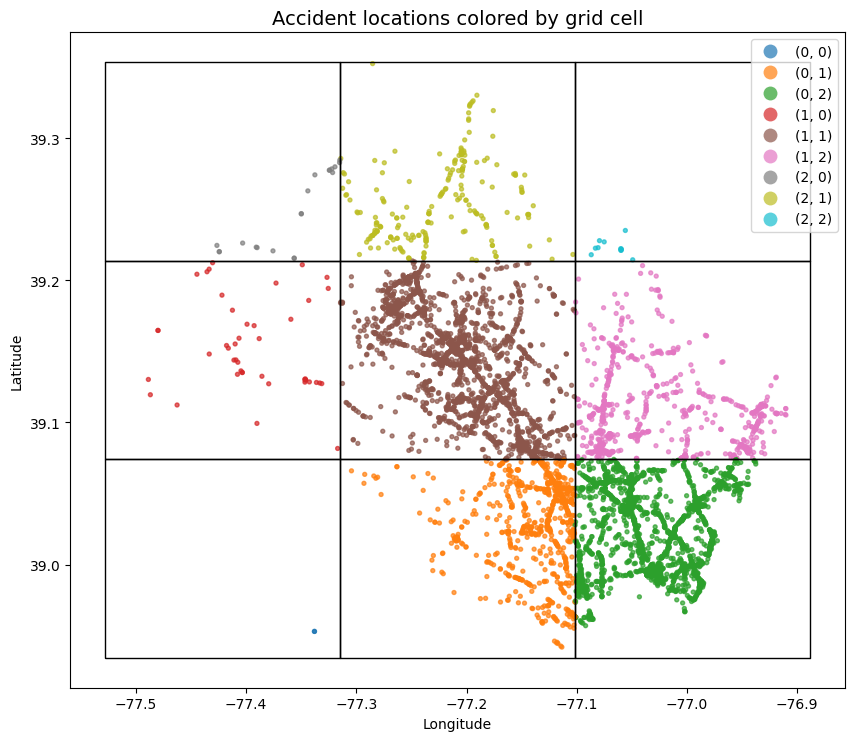

In [30]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import pandas as pd

lat_min = 38.934343
lat_max = 39.353502
lon_min = -77.52768
lon_max = -76.888505
# Create geometry column from Latitude / Longitude
geometry = [
    Point(lon, lat)
    for lon, lat in zip(
        car_accidents_data['Longitude'],
        car_accidents_data['Latitude']
    )
]

gdf = gpd.GeoDataFrame(
    car_accidents_data,
    geometry=geometry,
    crs="EPSG:4326"
)

polygons = []
cells = []

for (i, j), (lat_min, lat_max, lon_min, lon_max) in grid.items():
    poly = Polygon([
        (lon_min, lat_min),
        (lon_max, lat_min),
        (lon_max, lat_max),
        (lon_min, lat_max)
    ])
    polygons.append(poly)
    cells.append(f"({i}, {j})")

grid_gdf = gpd.GeoDataFrame(
    {'grid_cell': cells},
    geometry=polygons,
    crs="EPSG:4326"
)

gdf['grid_cell_str'] = gdf['grid_cell'].astype(str)

fig, ax = plt.subplots(figsize=(10, 10))

# Plot grid boundaries
grid_gdf.boundary.plot(
    ax=ax,
    color='black',
    linewidth=1
)

# Plot accident points colored by grid cell
gdf.plot(
    ax=ax,
    column='grid_cell_str',
    cmap='tab10',
    markersize=8,
    legend=True,
    alpha=0.7
)

ax.set_title("Accident locations colored by grid cell", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()


### Code using the API with a function (timezone "UTC-5")

In [ ]:
import openmeteo_requests
import pandas as pd
import requests_cache
from retry_requests import retry
from datetime import datetime, timezone, timedelta

url = "https://archive-api.open-meteo.com/v1/archive"

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

def weather_api(latitude, longitude, start_date, end_date):
# Function to get weather data from OpenMeteo API
# Return a json with hourly and daily data

# The order of variables in hourly or daily is important (to assign them correctly below)

    params = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": start_date,
        "end_date": end_date,
        "timezone": "UTC-5",
        "hourly": ["temperature_2m", "apparent_temperature", "relative_humidity_2m", "weather_code", "precipitation", "snowfall", "wind_speed_10m", "wind_direction_10m", "soil_temperature_0_to_7cm", "soil_moisture_0_to_7cm", "shortwave_radiation", "direct_radiation", "direct_normal_irradiance", "diffuse_radiation", "global_tilted_irradiance", "sunshine_duration"],
        "daily": ["sunrise", "sunset"]
    }

    responses = openmeteo.weather_api(url, params=params)
    #print(responses)

    response = responses[0]

    #print(f"Coordinates: {response.Latitude()}°N {response.Longitude()}°E")
    #print(f"Elevation: {response.Elevation()} m asl")
    #print(f"Timezone difference to GMT+0: {response.UtcOffsetSeconds()}s")

    # Process hourly data. The order of variables needs to be the same as requested.
    hourly = response.Hourly()
    temperature = hourly.Variables(0).ValuesAsNumpy()
    apparent_temperature = hourly.Variables(1).ValuesAsNumpy()
    humidity = hourly.Variables(2).ValuesAsNumpy()
    weather_code = hourly.Variables(3).ValuesAsNumpy()
    precipitation = hourly.Variables(4).ValuesAsNumpy()
    snowfall = hourly.Variables(5).ValuesAsNumpy()
    wind_speed = hourly.Variables(6).ValuesAsNumpy()
    wind_direction = hourly.Variables(7).ValuesAsNumpy()
    soil_temperature = hourly.Variables(8).ValuesAsNumpy()
    soil_moisture = hourly.Variables(9).ValuesAsNumpy()
    shortwave_radiation = hourly.Variables(10).ValuesAsNumpy()
    direct_radiation = hourly.Variables(11).ValuesAsNumpy()
    direct_normal_irradiance = hourly.Variables(12).ValuesAsNumpy
    diffuse_radiation = hourly.Variables(13).ValuesAsNumpy()
    global_tilted_irradiance = hourly.Variables(14).ValuesAsNumpy
    sunshine_duration = hourly.Variables(15).ValuesAsNumpy()

    
    daily = response.Daily()

    daily_sunrise = daily.Variables(0).ValuesInt64AsNumpy()
    daily_sunset = daily.Variables(1).ValuesInt64AsNumpy()

    utc_minus_5 = timezone(timedelta(hours=-5))

    daily_sunrise= datetime.fromtimestamp(daily_sunrise[0],tz=utc_minus_5).isoformat()
    daily_sunset= datetime.fromtimestamp(daily_sunset[0], tz=utc_minus_5).isoformat()
    
    
    hourly_data = {"date": pd.date_range(
        start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
        end =  pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
        freq = pd.Timedelta(seconds = hourly.Interval()),
        inclusive = "left"
    )}

    hourly_data["temperature"] = temperature
    hourly_data["apparent_temperature"] = apparent_temperature
    hourly_data["humidity"] = humidity
    hourly_data["weather_code"] = weather_code
    hourly_data["precipitation"] = precipitation
    hourly_data["snowfall"] = snowfall
    hourly_data["wind_speed"] = wind_speed
    hourly_data["wind_direction"] = wind_direction
    hourly_data["soil_temperature"] = soil_temperature
    hourly_data["soil_moisture"] = soil_moisture
    """
    hourly_data["shortwave_radiation"] = shortwave_radiation
    hourly_data["direct_radiation"] = direct_radiation
    hourly_data["direct_normal_irradiance"] = direct_normal_irradiance
    hourly_data["diffuse_radiation"] = diffuse_radiation
    hourly_data["global_tilted_irradiance"] = global_tilted_irradiance
    hourly_data["sunshine_duration"] = sunshine_duration
    """
    
    daily_data = {"date": pd.date_range(
        start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
        end =  pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
        freq = pd.Timedelta(seconds = daily.Interval()),
        inclusive = "left"
    )}

    daily_data["sunrise"] = daily_sunrise
    daily_data["sunset"] = daily_sunset
    

    return {"hourly": hourly_data, "daily": daily_data}

#weather_api(52.52, 13.41, "2025-11-09", "2025-11-09")

weather_api(39.2903848, -76.6121893, "2025-01-01", "2025-01-01")
#add_weather()

{'hourly': {'date': DatetimeIndex(['2025-01-01 05:00:00+00:00', '2025-01-01 06:00:00+00:00',
                 '2025-01-01 07:00:00+00:00', '2025-01-01 08:00:00+00:00',
                 '2025-01-01 09:00:00+00:00', '2025-01-01 10:00:00+00:00',
                 '2025-01-01 11:00:00+00:00', '2025-01-01 12:00:00+00:00',
                 '2025-01-01 13:00:00+00:00', '2025-01-01 14:00:00+00:00',
                 '2025-01-01 15:00:00+00:00', '2025-01-01 16:00:00+00:00',
                 '2025-01-01 17:00:00+00:00', '2025-01-01 18:00:00+00:00',
                 '2025-01-01 19:00:00+00:00', '2025-01-01 20:00:00+00:00',
                 '2025-01-01 21:00:00+00:00', '2025-01-01 22:00:00+00:00',
                 '2025-01-01 23:00:00+00:00', '2025-01-02 00:00:00+00:00',
                 '2025-01-02 01:00:00+00:00', '2025-01-02 02:00:00+00:00',
                 '2025-01-02 03:00:00+00:00', '2025-01-02 04:00:00+00:00'],
                dtype='datetime64[ns, UTC]', freq='h'),
  'temperature': array([7

### Function that add the weather data to the data set

In [ ]:
import time
import os

# if the file "completed_dataset_sample.csv" exists, we load it instead of the initial dataset, to avoid redoing already completed work
if os.path.exists("completed_dataset_sample.csv"):
    car_accidents_data = pd.read_csv("completed_dataset_sample.csv") # usecols=usecols) to select specific columns
else:
    car_accidents_data = pd.read_csv("bigbase_sample_clean.csv") # usecols=usecols) to select specific columns

def add_weather():
    n = len(car_accidents_data)

    # adding weather columns to car_accidents_data

    weather_columns_hourly = [
        "temperature",
        "apparent_temperature",
        "humidity",
        "weather_code",
        "precipitation",
        "snowfall",
        "wind_speed",
        "wind_direction",
        "soil_temperature",
        "soil_moisture"
    ]

    weather_columns_daily = [
        "sunrise",
        "sunset",
        "day_or_night_code"]
    
    weather_columns = weather_columns_hourly + weather_columns_daily

    new_data = {col: [None] * n for col in weather_columns}
    for col, values in new_data.items():
        if col not in car_accidents_data.columns: # to avoid overwriting existing columns with data coming form previous runs
            car_accidents_data[col] = values
    
    #show the full updated dataframe
    #print("Updated car_accidents_data with new weather columns:")
    #print(car_accidents_data.head())
    
    j, k = 0, 0

    start_time = time.perf_counter()
    for i in range(0,n):
        j+=1
        print(f"Processing row {i}, meaning row {j} of the {k} series, out of {n}")
        latitude = car_accidents_data.iloc[i]['Latitude']
        longitude = car_accidents_data.iloc[i]['Longitude']
        date_time = car_accidents_data.iloc[i]['Crash Date/Time']

        date = date_time.split(" ")[0]
        accident_time = date_time.split(" ")[1] #useless
        

        hour = date_time.split(" ")[1].split(":")[0]
        time_of_day = date_time.split(" ")[2]
        time_minutes = date_time.split(" ")[1].split(":")[1]

        time_index = int(hour) # index starts at 0 for midnight, so 1am = 1, 2am = 2, ..., 12pm = 12, 1pm = 13, ..., 11pm = 23

        if time_of_day == "PM" and hour != "12":
            time_index += 12
        elif time_of_day == "AM" and hour == "12":
            time_index = 0

        if time_minutes < "30":
            time_index += 0
        elif int(hour) < 11 :
            time_index += 1

        #print(f"Fetching weather data for row {i} (ID: {car_accidents_data.index[i]}) at coordinates: {latitude}, {longitude}")
        #print(f"Crash Date/Time: {date_time}")
        print(f"Parsed Date: {date}, Time: {accident_time}, Hour: {hour}, Time of Day: {time_of_day}, Time Minutes: {time_minutes}")
        #print(f"Computed Time Index for hourly data: {time_index}")

        date_conversion = pd.to_datetime(date)
        date_for_api = date_conversion.strftime("%Y-%m-%d")
        #print(f"Formatted Date for API: {date_for_api}")

        weather_data = weather_api(latitude, longitude, date_for_api, date_for_api)

        # Extract hourly weather data for the specific hour of the crash
        hourly_data = weather_data["hourly"]
        daily_data = weather_data["daily"]

        #print(hourly_data)
        #print('Daily data:')
        #print(daily_data)

        for col in weather_columns_hourly:
            if col in hourly_data:
                print("Time index:", time_index)
                car_accidents_data.at[i, col] = hourly_data[col][time_index]
                #print(f"Assigned {col} value: {hourly_data[col][time_index]} to row {i} (ID: {car_accidents_data.index[i]})")
            else:
                print(f"Warning: {col} not found in hourly data for row {i} (ID: {car_accidents_data.index[i]})")
            
        col = "day_or_night_code"
        if "sunrise" in daily_data and "sunset" in daily_data:
            sunrise_time = daily_data["sunrise"]
            #print(f"Sunrise time: {sunrise_time}")
            sunrise_time_list = sunrise_time.split("T")[1].split(":")[0:2]
            sunrise_time_h, sunrise_time_m = sunrise_time_list[0], sunrise_time_list[1]
            #print(f"Sunrise time (hour) and minute): {sunrise_time_h} {sunrise_time_m}")

            sunrise_time_hm = sunrise_time_h + ":" + sunrise_time_m + ":00"

            sunset_time = daily_data["sunset"]
            sunset_time_list = sunset_time.split("T")[1].split(":")[0:2]
            sunset_time_h, sunset_time_m = sunset_time_list[0], sunset_time_list[1]
            #print(f"Sunset time (hour and minute): {sunset_time_h} {sunset_time_m}")

            sunset_time_hm = sunset_time_h + ":" + sunset_time_m + ":00"

            if time_of_day == "PM" and hour != "12":
                accident_hour_24h = int(hour) + 12
            elif time_of_day == "AM" and hour == "12":
                accident_hour_24h = 00
            else :
                accident_hour_24h = int(hour)

            if accident_hour_24h < 10:
                accident_hour_24h = "0" + str(accident_hour_24h)
            accident_time_24h = str(accident_hour_24h) + ":" + time_minutes + ":00"

            if sunrise_time_hm <= accident_time_24h <= sunset_time_hm:
                #print(f"Crash time {time} is during the day (between {sunrise_time_hm} and {sunset_time_hm})")
                car_accidents_data.at[i, col] = "0"
            else:
                #print(f"Crash time {time} is during the night (outside {sunrise_time_hm} and {sunset_time_hm})")
                car_accidents_data.at[i, col] = "1"
            
            #print(f"Assigned {col} value: {car_accidents_data.at[i, col]} to row {i} (ID: {car_accidents_data.index[i]})")

            # we add the sunrise and sunset times to the dataframe, because it could be useful later to identify crashes at times close to sunrise/sunset
            car_accidents_data.at[i, "sunrise"] = sunrise_time_hm
            car_accidents_data.at[i, "sunset"] = sunset_time_hm
        else:
            print(f"Warning: sunrise or sunset not found in daily data for row {i} (ID: {car_accidents_data.index[i]})")
        
        if j > 300 :
            # Update the CSV file after each batch of 550 requests
            #car_accidents_data.to_csv("completed_dataset_sample.csv")

            end_time = time.perf_counter()
            elapsed = end_time - start_time
            print(f"Elapsed time for 550 requests: {elapsed} seconds")

            time.sleep(120) # to respect rate limit of 600 requests per minute (with a security margin of 4 seconds)
            j = 0
            k += 1
            start_time = time.perf_counter()

    # Saving the dataframe as a csv file

    # Export the file to the current working directory
    #car_accidents_data.to_csv("completed_dataset_sample.csv")

    return

add_weather()

Processing row 0, meaning row 1 of the 0 series, out of 6498
Parsed Date: 04/12/2022, Time: 07:40:00, Hour: 07, Time of Day: AM, Time Minutes: 40
Time index: 8
Time index: 8
Time index: 8
Time index: 8
Time index: 8
Time index: 8
Time index: 8
Time index: 8
Time index: 8
Time index: 8


/var/folders/5v/9b211qsj52sgwg1mx65bdc9m0000gn/T/ipykernel_82529/2294434645.py:130: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  car_accidents_data.at[i, col] = "0"


In [ ]:
car_accidents_data.head()

,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,Report Number,Local Case Number,Agency Name,ACRS Report Type,Crash Date/Time,...,weather_code,precipitation,snowfall,wind_speed,wind_direction,soil_temperature,soil_moisture,sunrise,sunset,day_or_night_code
0,0,0,0,0,0,MCP3130004M,220015468,Montgomery County Police,Property Damage Crash,04/12/2022 07:40:00 AM,...,51.0,0.3,0.0,10.829959,285.422211,11.233001,0.459,05:35:00,18:42:00,1
1,1,1,1,1,1,MCP29520027,16031710,Montgomery County Police,Injury Crash,06/23/2016 10:35:00 AM,...,63.0,3.2,0.0,4.320000,270.000000,21.872499,0.518,04:43:00,19:37:00,0
2,2,2,2,2,2,MCP1048001D,16011658,MONTGOMERY,Property Damage Crash,03/09/2016 07:00:00 AM,...,2.0,0.0,0.0,6.120000,241.927612,8.493999,0.439,06:28:00,18:09:00,1
3,3,3,3,3,3,MCP2667004Q,180023612,Montgomery County Police,Injury Crash,05/14/2018 06:55:00 AM,...,3.0,0.0,0.0,3.319036,139.398788,15.491500,0.407,04:55:00,19:13:00,1
4,4,4,4,4,4,MCP3030003D,200018469,Montgomery County Police,Property Damage Crash,05/06/2020 03:02:00 PM,...,61.0,1.5,0.0,12.599998,323.130005,12.625000,0.506,05:04:00,19:06:00,0


### Correction of the day_or_night_code column to take PM into account

In [ ]:
if os.path.exists("completed_dataset_sample.csv"):
    car_accidents_data = pd.read_csv("completed_dataset_sample.csv") # usecols=usecols) to select specific columns
else:
    print("The file does not exist.")

n = len(car_accidents_data)
for i in range(0,n):

    date_time = car_accidents_data.iloc[i]['Crash Date/Time']

    accident_time = date_time.split(" ")[1] #useless
    hour = date_time.split(" ")[1].split(":")[0]
    time_of_day = date_time.split(" ")[2]
    time_minutes = date_time.split(" ")[1].split(":")[1]

    if time_of_day == "PM" and hour != "12":
        accident_hour_24h = int(hour) + 12
    elif time_of_day == "AM" and hour == "12":
        accident_hour_24h = 00
    else :
        accident_hour_24h = int(hour)

    if accident_hour_24h < 10:
        accident_hour_24h = "0" + str(accident_hour_24h)
    accident_time_24h = str(accident_hour_24h) + ":" + time_minutes + ":00"

    sunrise_time = car_accidents_data.iloc[i]['sunrise']
    sunset_time = car_accidents_data.iloc[i]['sunset']

    if sunrise_time <= accident_time_24h <= sunset_time:
        car_accidents_data.at[i, "day_or_night_code"] = "0"
        print(f"Daytime crash at row {i}: accident time {accident_time_24h}, sunrise {sunrise_time}, sunset {sunset_time}")
    else:
        car_accidents_data.at[i, "day_or_night_code"] = "1"
        print(f"Nighttime crash at row {i}: accident time {accident_time_24h}, sunrise {sunrise_time}, sunset {sunset_time}")
    
   #print(f"Processed row {i} out of {n}")

car_accidents_data.head()
car_accidents_data.to_csv("completed_dataset_sample.csv")

/var/folders/5v/9b211qsj52sgwg1mx65bdc9m0000gn/T/ipykernel_82529/1289435743.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  car_accidents_data.at[i, "day_or_night_code"] = "0"


Daytime crash at row 0: accident time 07:40:00, sunrise 05:35:00, sunset 18:42:00
Daytime crash at row 1: accident time 10:35:00, sunrise 04:43:00, sunset 19:37:00
Daytime crash at row 2: accident time 07:00:00, sunrise 06:28:00, sunset 18:09:00
Daytime crash at row 3: accident time 06:55:00, sunrise 04:55:00, sunset 19:13:00
Daytime crash at row 4: accident time 15:02:00, sunrise 05:04:00, sunset 19:06:00
Daytime crash at row 5: accident time 14:01:00, sunrise 06:18:00, sunset 18:16:00
Daytime crash at row 6: accident time 10:35:00, sunrise 05:04:00, sunset 19:07:00
Daytime crash at row 7: accident time 08:20:00, sunrise 07:17:00, sunset 17:26:00
Daytime crash at row 8: accident time 13:53:00, sunrise 05:45:00, sunset 18:36:00
Daytime crash at row 9: accident time 12:08:00, sunrise 05:36:00, sunset 18:41:00
Daytime crash at row 10: accident time 15:57:00, sunrise 07:24:00, sunset 17:11:00
Daytime crash at row 11: accident time 15:25:00, sunrise 07:27:00, sunset 17:06:00
Daytime crash 

# Drafts part

### Code to use the API manually (not required in the final version of the project)

In [ ]:
import openmeteo_requests

import pandas as pd
import requests_cache
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 52.52,
	"longitude": 13.41,
	"start_date": "2025-11-09",
	"end_date": "2025-11-11",
	"hourly": ["temperature_2m", "relative_humidity_2m", "weather_code", "precipitation", "snowfall" ],
    "daily": ["sunrise", "sunset"]
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates: {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation: {response.Elevation()} m asl")
print(f"Timezone difference to GMT+0: {response.UtcOffsetSeconds()}s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
weather_code = hourly.Variables(2).ValuesAsNumpy()
precipitation = hourly.Variables(3).ValuesAsNumpy()
snowfall = hourly.Variables(4).ValuesAsNumpy()

daily = response.Daily()
daily_sunrise = daily.Variables(0).ValuesAsNumpy()
daily_sunset = daily.Variables(1).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end =  pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}

hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m
hourly_data["weather_code"] = weather_code
hourly_data["precipitation"] = precipitation
hourly_data["snowfall"] = snowfall

daily_data = {"date": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
	end =  pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left"
)}

daily_data["sunrise"] = daily_sunrise
daily_data["sunset"] = daily_sunset

hourly_dataframe = pd.DataFrame(data = hourly_data)
print("\nHourly data\n", hourly_dataframe)

daily_dataframe = pd.DataFrame(data = daily_data)
print("\nDaily data\n", daily_dataframe)


Coordinates: 52.5483283996582°N 13.407821655273438°E
Elevation: 38.0 m asl
Timezone difference to GMT+0: 0s

Hourly data
                         date  temperature_2m  relative_humidity_2m  \
0  2025-11-09 00:00:00+00:00          2.3585            100.000000   
1  2025-11-09 01:00:00+00:00          1.5585             99.286285   
2  2025-11-09 02:00:00+00:00          1.6585             97.174431   
3  2025-11-09 03:00:00+00:00          1.4085             99.642143   
4  2025-11-09 04:00:00+00:00          1.3085             98.574203   
..                       ...             ...                   ...   
67 2025-11-11 19:00:00+00:00          7.6085             96.641724   
68 2025-11-11 20:00:00+00:00          6.9585             96.957458   
69 2025-11-11 21:00:00+00:00          6.5085             96.946640   
70 2025-11-11 22:00:00+00:00          6.5085             96.946640   
71 2025-11-11 23:00:00+00:00          6.6585             96.950264   

    weather_code  precipitation  snow

# Découpage en carrés